# RNN to Predict the Language of a Word

For an assignment, I implement a character-level vanilla RNN to predict whether a single word is German or English.

In [2]:
# Load colab packages
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('words')
import random

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


# Load and prep data

In [8]:
from nltk.corpus import words

# Load data
def load_data():
  '''Wrapper to load data'''

  random.seed(42)

  # Select words per language

  n=25000

  # Sample English words
  english_words = words.words()
  english_words = random.sample(english_words, n)
  labels_english = [0] * len(english_words)

  # Sample German words
  with open('/content/drive/My Drive/08_NN_Kaparthy/RNN/data/wordlist-german.txt', 'r', encoding='utf-8') as f:
    words_german = f.read().strip().split('\n')

  words_german = random.sample(words_german, n)
  labels_german = [1] * len(words_german)

  # Combine and shuffle words
  all_words = english_words + words_german
  all_labels = labels_english + labels_german

  shuffled_indices = list(range(len(all_words)))
  random.shuffle(shuffled_indices)
  all_words = [all_words[i] for i in shuffled_indices]
  all_labels = [all_labels[i] for i in shuffled_indices]

  return all_words, all_labels

In [9]:
# Num words and unique chars
words, labels = load_data()

print("Num words: ", len(words))
print("Show distribution: ", np.unique(labels, return_counts=True))

Num words:  50000
Show distribution:  (array([0, 1]), array([25000, 25000]))


In [10]:
# Create char list
chars = sorted(list(set(''.join(words))))
vocab_size = len(chars)
print("Unique sorted chars: ",''.join(chars))
print('Unique chars: ', vocab_size)

Unique sorted chars:  ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyzÄÅÖÜßáäèéêëöü
Unique chars:  65


In [11]:
# tokenise = convert raw chars to seq of integers
stoi = {ch:i for i,ch in enumerate(chars)}
# function to take str/int and output int/str
encode = lambda s: torch.tensor([stoi[c] for c in s], dtype=torch.long)

In [12]:
# Crate one-hot
def wordToOneHot(word):
    '''Create one-hot vector for word'''
    oneHotWord = torch.zeros(len(word), vocab_size) # T, vocab_size
    for i, char in enumerate(word):
        oneHotWord[i][stoi[char]] = 1
    return oneHotWord

In [13]:
# Example
wordToOneHot("gross").shape

torch.Size([5, 65])

In [14]:
# Train test sampels
n=int(len(words)*.8)
words_train = words[:n]
labels_train = labels[:n]
words_test = words[n:]
labels_test = labels[n:]

print('len train', len(words_train))
print('len test', len(words_test))

len train 40000
len test 10000


In [15]:
# Check some words
print(words_train[:5], labels_train[:5])
print(np.unique(labels_train, return_counts=True))

['Geschichtswissenschaften', 'Faktorausstattung', 'Spareinlagenbücher', 'Bemba', 'perceivance'] [1, 1, 1, 0, 0]
(array([0, 1]), array([20045, 19955]))


This is a simple RNN with one cell.

Model can be advanced on multiple ends:

*   More cells
*   LSTM, GRU cells (preferably for longer networks)
*   Adding an embedding table as trainable params
*   Adding dropout



In [16]:
# Define model
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.hidden_size = hidden_size

        self.embedding_table = nn.Embedding(input_size, hidden_size)
        #self.charToHidden = nn.Linear(input_size, hidden_size)
        self.hiddenToHidden = nn.Linear(hidden_size, hidden_size)
        self.hiddenToOutput = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        #emb = self.charToHidden(input) # 1, hidden_size
        emb = self.embedding_table(input) # 1, hidden_size
        hidden = self.hiddenToHidden(hidden) # 1, hidden_size x hidden_size, hidden_size = 1, hidden_size
        new_hidden = torch.tanh(emb + hidden) # 1, hidden_size
        logits = self.hiddenToOutput(new_hidden) # 1, output_size
        return logits, new_hidden # 1, output_size; 1 x 128

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [17]:
n_hidden = 128
# input size = vocab size due to one-hot
rnn = RNN(vocab_size, n_hidden, 2)

In [18]:
# Example name and output
example = wordToOneHot("Deutsch") # T, 1, vocab_size
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(torch.tensor([1]), hidden)
#output, next_hidden = rnn(example[0], hidden)
print(output)

tensor([[0.3816, 0.2514]], grad_fn=<AddmmBackward0>)


# Training


Function to sample a single name, label, and one-hot representation from either training or test data.

In [19]:
def random_sample(data:str, word=None):
    '''''Sample a single name, label, and one-hot representation from either training or test data'''

    # Sample from the training set
    if data == 'train':
      idx = torch.randint(len(words_train), size=(1,))
      word = words_train[idx]
      word_encoded = encode(word)
      label = torch.tensor([labels_train[idx]], dtype=torch.long)

      return word_encoded, label

    # Return above for test name
    else:
      word_encoded = encode(word)
      label = torch.tensor([labels_test[words_test.index(word)]], dtype=torch.long)

      return word_encoded, label

In [ ]:
# def random_sample(data:str, word=None):
#     '''''Sample a single name, label, and one-hot representation from either training or test data'''

#     # Sample from the training set
#     if data == 'train':
#       idx = torch.randint(len(words_train), size=(1,))
#       word = words_train[idx]
#       words_oH = wordToOneHot(word)
#       label = torch.tensor([labels_train[idx]], dtype=torch.long)

#       return word, words_oH, label

#     # Return above for test name
#     else:
#       word_oH = wordToOneHot(word)
#       label = torch.tensor([labels_test[words_test.index(word)]], dtype=torch.long)

#       return word, word_oH, label

In [20]:
# Example for test set
random_sample('test', words_test[0])

(tensor([38, 40, 43, 36, 34, 39]), tensor([0]))

In [21]:
# Initiate optmizer; can play around, tendency for higher LR as network is small
learning_rate=.0001
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

In [23]:
# Params
n_iters = len(words_train) *2 # Run the training data twice
eval_at = 5000
loss_at = 5000
losses=[]
losses_at=[]

rnn.train()

# Run training loop
for iter in range(0, n_iters + 1):

    # Get training example
    word_encoded, label = random_sample('train')

    # Training
    hidden = rnn.initHidden()

    # Loop chars
    for i, charint in enumerate(word_encoded):
    #for i in range(len(name)):
        # Index each char
        output, hidden = rnn(charint, hidden)

    loss = F.cross_entropy(output, label)
    losses.append(loss.item())

    optimizer.zero_grad(set_to_none=True)
    # backprop and step
    loss.backward()
    optimizer.step()

    if iter % eval_at == 0:
      print(f"Iteration {iter}/{n_iters} Avg loss: {sum(losses)/eval_at:.5f}")
      losses = []

    if iter % loss_at == 0 or iter==0:
        losses_at.append(loss.item()/loss_at)
        losses_at=[]

Iteration 0/80000 Avg loss: 0.00013
Iteration 5000/80000 Avg loss: 0.44257
Iteration 10000/80000 Avg loss: 0.23301
Iteration 15000/80000 Avg loss: 0.14771
Iteration 20000/80000 Avg loss: 0.13226
Iteration 25000/80000 Avg loss: 0.10778
Iteration 30000/80000 Avg loss: 0.09797
Iteration 35000/80000 Avg loss: 0.08328
Iteration 40000/80000 Avg loss: 0.09000
Iteration 45000/80000 Avg loss: 0.08997
Iteration 50000/80000 Avg loss: 0.08720
Iteration 55000/80000 Avg loss: 0.08172
Iteration 60000/80000 Avg loss: 0.07858
Iteration 65000/80000 Avg loss: 0.07834
Iteration 70000/80000 Avg loss: 0.07464
Iteration 75000/80000 Avg loss: 0.06861
Iteration 80000/80000 Avg loss: 0.07114


In [27]:
losses_at

[]

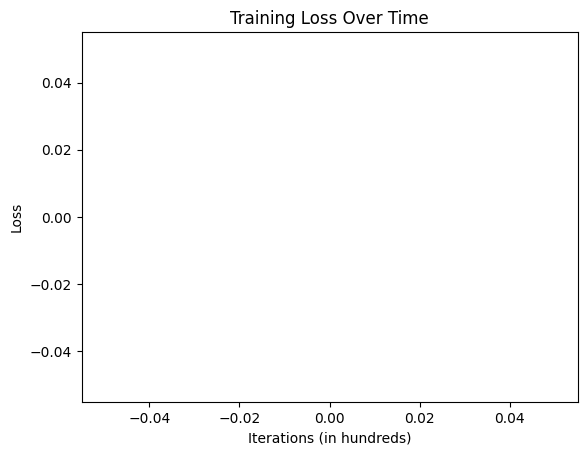

In [28]:
# Plot loss
plt.figure()
plt.plot(losses)
plt.xlabel('Iterations (in hundreds)')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()

## Training and Test Performance


In [29]:
# Eval
def evaluate(word_encoded, label):

    rnn.eval()

    with torch.no_grad():
      hidden = rnn.initHidden()

      for charint in word_encoded:
          output, hidden = rnn(charint, hidden)
          pred = torch.argmax(output, dim=1)
      return int(pred == label)

## Training Set Accuracy

In [30]:
tr_n = 500
tr_acc = torch.tensor([0], dtype=torch.float)

for i in range(0, tr_n):
    word_encoded, label = random_sample('train')
    tr_acc += evaluate(word_encoded, label)

print("Train acc ", tr_acc/tr_n)

Train acc  tensor([0.9840])


## Test Set Accuracy

In [31]:
te_acc = torch.tensor([0], dtype=torch.float)

for word in words_test:
    word_encoded, label = random_sample('test', word)
    te_acc += evaluate(word_encoded, label)

print("Test acc ", te_acc/len(words_test))

Test acc  tensor([0.9686])


In [32]:
def predict_language(word: str):
  word_encoded = encode(word)
  rnn.eval()
  with torch.no_grad():
    hidden = rnn.initHidden()
    for charint in word_encoded:
      output, hidden = rnn(charint, hidden)

    probs = F.softmax(output, dim=1)
    pred = torch.argmax(output, dim=1)

  return f"German {probs[0][pred].item()*100:.0f}%" if int(pred) == 1 else f"English {probs[0][pred].item()*100:.0f}%"

In [56]:
ood = ["Ich", "liebe", "Sprachverarbeitung"]
for word in ood:
  print(word, "==>", predict_language(word), "Out of distribution? ", word not in words)

Ich ==> German 76% Out of distribution?  True
liebe ==> German 59% Out of distribution?  True
Sprachverarbeitung ==> German 100% Out of distribution?  True


In [59]:
ood = ["I", "love", "naturallanguage"]
for word in ood:
  print(word, "==>", predict_language(word), "Out of distribution? ", word not in words)

I ==> German 98% Out of distribution?  True
love ==> English 99% Out of distribution?  False
naturallanguage ==> English 51% Out of distribution?  True
